<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [1]:
#Importing Libraries 
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd 
import datetime #Convert to unix time
import time #Convert to unix time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams#Size of plots
from sklearn.cluster import MiniBatchKMeans, KMeans
from tqdm import tqdm
import math
import pickle
import os
import xgboost as xgb
import warnings
import networkx as nx
import pdb
import pickle
import random
from pandas import HDFStore,DataFrame
from scipy.sparse.linalg import svds, eigs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint
from scipy.stats import uniform
from pandas import read_hdf

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import xgboost as xgb


<h2> 0. Reading EdgeList from the Dataset</h2>

In [2]:
#reading graph
if not os.path.isfile('train_woheader.csv'):
    trainData = pd.read_csv('train.csv')
    print(trainData[trainData.isna().any(1)])
    print(trainData.info())
    print("Number of diplicate entries: ",sum(trainData.duplicated()))
    trainData.to_csv('train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


<h3> 0.1 Samping 50 rows for graph Visualization </h3>

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.ite

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable i

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


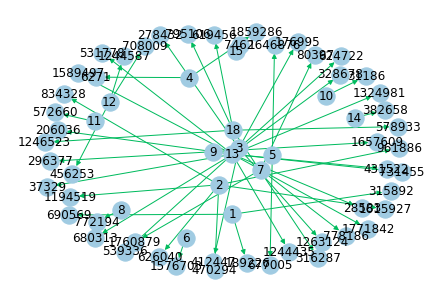

In [3]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph = nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib
pos = nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [4]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


## 1.1 No of followers for each person

<h3> 1.1.1 Indegree count plot </h3>

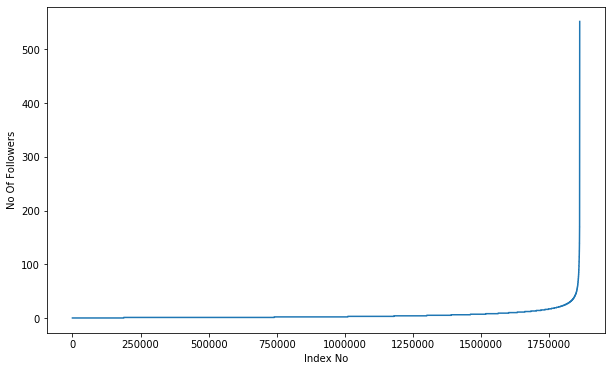

In [5]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

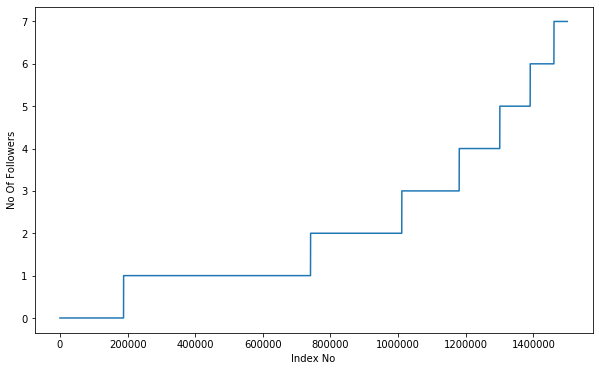

In [6]:
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

<h3> 1.1.2 Box Plot </h3>

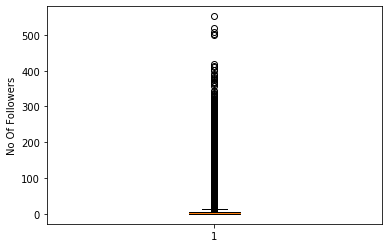

In [7]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [8]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


In [9]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


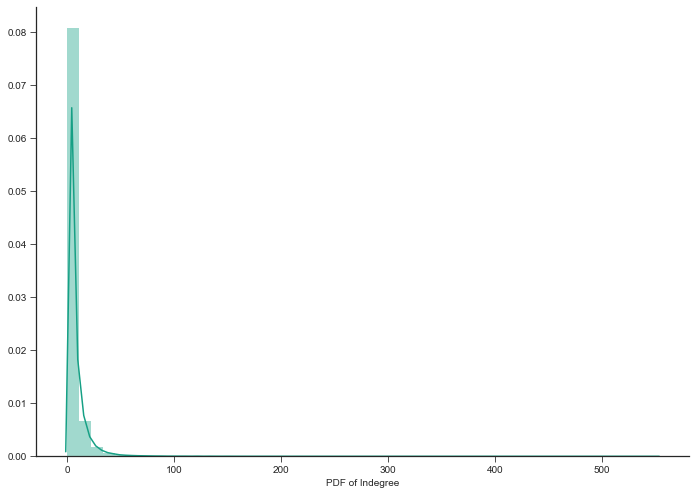

In [10]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

## 1.2 No of people each person is following

<h3> 1.2.1 Outdegree count plot </h3>

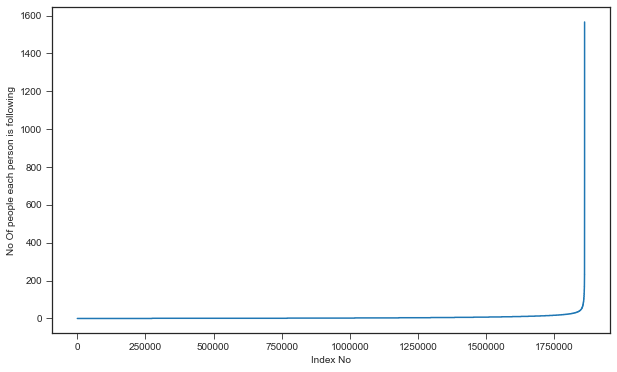

In [11]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

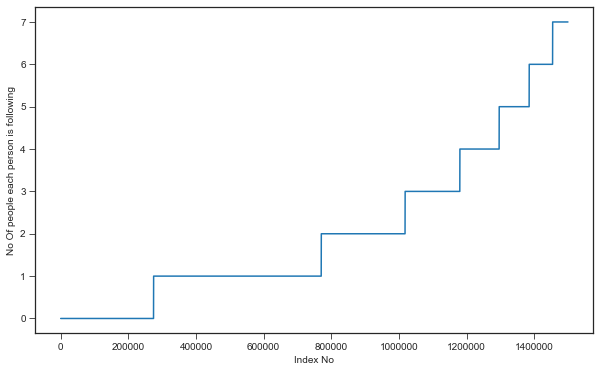

In [12]:
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

<h3> 1.2.2 Box plot </h3>

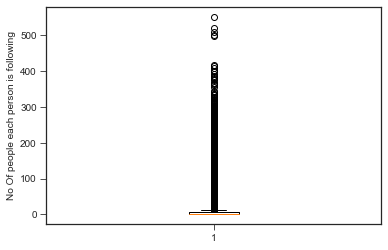

In [13]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

In [14]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [15]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


<h3> 1.2.3 Histogram(PDF) </h3>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


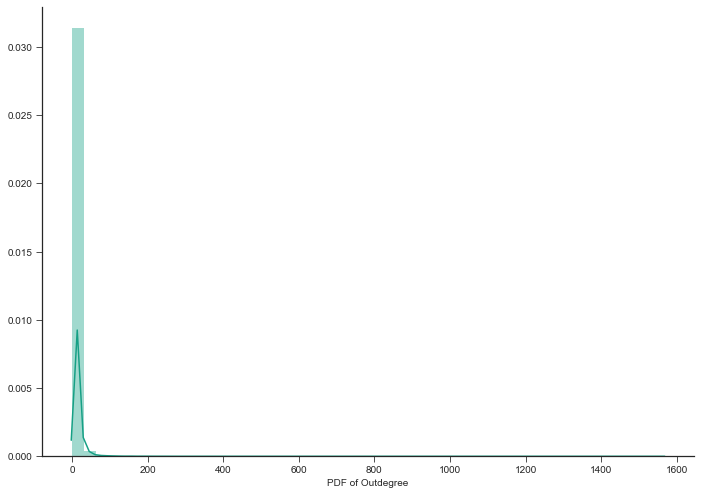

In [16]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [17]:
print('No of users not following anyone are' ,sum(np.array(outdegree_dist)==0),'and the percentage is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of users not following anyone are 274512 and the percentage is 14.741115442858524


In [19]:
print('No of users having zero followers is' ,sum(np.array(indegree_dist)==0),'and the percentage is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of users having zero followers is 188043 and the percentage is 10.097786512871734


In [20]:
# .predecessors and .successors are used to find the indegree and outdegree edges of a particular node(i) in a graph(g)
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of users not following anyone and also not having any followers are',count)

No of users not following anyone and also not having any followers are 0


## 1.3 both followers + following 

In [21]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

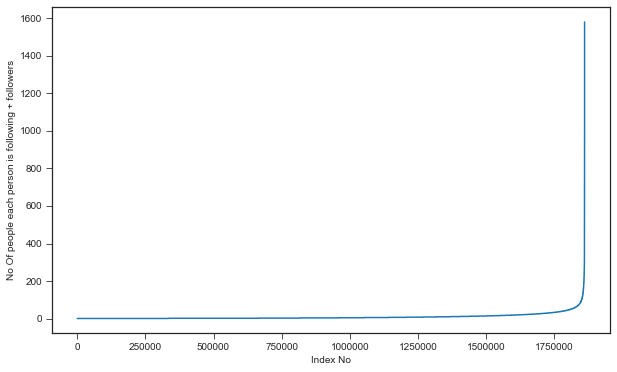

In [22]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

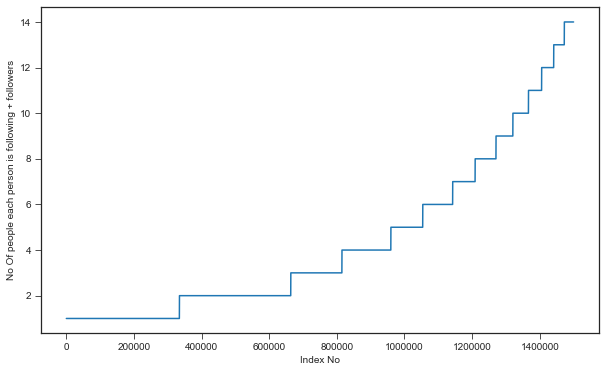

In [23]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [24]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [25]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [26]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')
print("`"*100)

print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')
print("`"*100)

print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))
print("`"*100)

print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i) == 2:
        count+=1
print('weakly connected components with 2 nodes',count)

Min of no of followers + following is 1
334291  persons having minimum no of followers + following
````````````````````````````````````````````````````````````````````````````````````````````````````
Max of no of followers + following is 1579
1  persons having maximum no of followers + following
````````````````````````````````````````````````````````````````````````````````````````````````````
No of persons having followers + following less than 10 are 1320326
````````````````````````````````````````````````````````````````````````````````````````````````````
No of weakly connected components 45558
weakly connected components with 2 nodes 32195


# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [27]:
%%time
###generating bad edges from given graph
if not os.path.isfile('missing_edges_final.p'):
    #getting all set of edges
    read_data = csv.reader(open('train_woheader.csv','r'))
    edges = dict()
    for edge in read_data:
        edges[(edge[0], edge[1])] = 1
            
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('missing_edges_final.p','rb'))

Wall time: 32.9 s


In [28]:
missing_edges = pickle.load(open('missing_edges_final.p','rb'))
len(missing_edges)

9437519

## 2.2 Training and Test data split:  
Taking the edges of graph and the missing links and splitting them into train and test sets.We are doing an 80:20 split and we are using RandomSearchcv for optimization which  takes care of cross validation internally from the train data 

In [29]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('~'*100)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('~'*100)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Training data only 
    print('deleting ........')
#     del missing_edges

deleting ........


## 2.3:  Analyzing Train and test data

In [2]:
train_graph = nx.read_edgelist('after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
test_graph = nx.read_edgelist('after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))
print(nx.info(test_graph))

# finding the unique nodes in the both train and test graphs
train_nodes_pos = set(train_graph.nodes())
test_nodes_pos = set(test_graph.nodes())

train_test_C = len(train_nodes_pos.intersection(test_nodes_pos))
train_test_N = len(train_nodes_pos - test_nodes_pos)
test_train_N = len(test_nodes_pos - train_nodes_pos)

print('no of people common in train and test -- ',train_test_C)
print('no of people present in train but not present in test -- ',train_test_N)

print('no of people present in test but not present in train -- ',test_train_N)
print(' % of people not there in Train but exist in total Test data are {} %'.format(test_train_N/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in total Test data are 7.1200735962845405 %


<h4> 2.2.1 Combining the positive and negative edges together to form the total data with positive and negative class.</h4>

-- So it becomes a binary classification problem where class 1 denotes edges are present and class 0 denotes egdes are missing.Given any two edges we need to predict whether a link should be present or not.

In [26]:
#final train and test data sets
if (not os.path.isfile('after_eda/train_after_eda.csv')) and \
(not os.path.isfile('after_eda/test_after_eda.csv')) and \
(not os.path.isfile('after_eda/train_y.csv')) and \
(not os.path.isfile('after_eda/test_y.csv')) and \
(os.path.isfile('after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile('after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('after_eda/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('after_eda/test_y.csv',header=False,index=False)

In [3]:
X_train = pd.read_csv("after_eda/train_after_eda.csv")
X_test = pd.read_csv("after_eda/test_after_eda.csv")
y_train = pd.read_csv("after_eda/train_y.csv")
y_test = pd.read_csv("after_eda/test_y.csv")

In [4]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of target variable in train",y_train.shape)
print("Shape of target variable in test", y_test.shape)

Data points in train data (15100029, 2)
Data points in test data (3775007, 2)
Shape of target variable in train (15100029, 1)
Shape of target variable in test (3775007, 1)


 # 3. Similarity measures

## 3.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [5]:
#for followees(successor)
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        jac = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
        return jac
    except:
        return 0
    

#for followers(predecessors)
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        jac = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return jac
    except:
        return 0

In [6]:
#one test case
print(jaccard_for_followees(273084,1505602))

#node 1635354 not in graph 
print(jaccard_for_followees(273084,1635354))

print(jaccard_for_followers(273084,470294))

#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))


0.0
0
0
0


## 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [6]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

    
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [8]:
print(cosine_for_followees(273084,1505602))

print(cosine_for_followees(273084,1635354))

print(cosine_for_followers(2,470294))

print(cosine_for_followers(669354,1635354))

0.0
0
0.02886751345948129
0


## 3. Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html




## 3.1 Page Ranking

https://en.wikipedia.org/wiki/PageRank

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

In [7]:
if not os.path.isfile('page_rank.p'):
    prank = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(prank,open('page_rank.p','wb'))
else:
    prank = pickle.load(open('page_rank.p','rb'))

In [8]:
print(type(prank))

<class 'dict'>


In [10]:
print('minimum page rank value :',prank[min(prank, key=prank.get)])
print('maximum page rank value :',prank[max(prank, key=prank.get)])
print('mean page rank value :',float(sum(prank.values())) / len(prank))

minimum page rank value : 1.6556497245737814e-07
maximum page rank value : 2.7098251341935827e-05
mean page rank value : 5.615699699389075e-07


In [9]:
#for imputing to nodes which are not there in Train data
mean_p_rank = float(sum(prank.values())) / len(prank)
print(mean_p_rank)

5.615699699389075e-07


# 4. Other Graph Features

<h3>4.1 Shortest path:

Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [10]:
#if has direct edge then deleting that edge and calculating shortest path
def shortest_path(x,y):
    q = -1
    try:
        if train_graph.has_edge(x,y):
            train_graph.remove_edge(x,y)
            q = nx.shortest_path_length(train_graph,source=x,target=y)
            train_graph.add_edge(x,y)
        else:
            q = nx.shortest_path_length(train_graph,source=x,target=y)
        return q
    except:
        return -1

In [49]:
#testing
#1)
print(shortest_path(669354,1635354))

10
-1


<h3>4.2 Checking for same Weakly Connected Components(Community) 

In [11]:
weakly_connected_comps = list(nx.weakly_connected_components(train_graph)) #getting weakly connected edges from graph 
#A Weakly Connected Component (WCC) is a subgraph of the original graph where all vertices are connected to each 
#other by some path, ignoring the direction of edges

#Function to check whether two edges belongs to the same weakly connected component.
def belong_to_same_wcc(a,b):
    wcc_ind = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in weakly_connected_comps:
                if a in i:
                    wcc_ind = i
                    break
            if (b in wcc_ind):
                train_graph.remove_edge(a,b)
                # if  shortest path between two edges other than the one connecting them exist, we consider them to belong
                # to same wcc
                if shortest_path(a,b) == -1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in weakly_connected_comps:
                if a in i:
                    wcc_ind = i
                    break
            if(b in wcc_ind):
                return 1
            else:
                return 0

In [ ]:
print(belong_to_same_wcc(1,189226))
print(belong_to_same_wcc(1535354,1435354))

<h3> 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [12]:
def adar_index(a,b):
    sum = 0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [19]:
#testing
adar_index(669354,1635354)

0

<h3> 4.4 Is persion was following back:

In [13]:
#if node 'a' follows node 'b', Does "b" follows "a" back?
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [ ]:
print(follows_back(1,189226))
print(follows_back(669354,1635354))

<h3> 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 
Katz centrality computes the centrality for a node 
based on the centrality of its neighbors. It is a 
generalization of the eigenvector centrality. The
Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [14]:
if not os.path.isfile('katz_centrality.p'):
    katz = nx.katz.katz_centrality(train_graph , alpha = 0.005 , beta = 1)
    pickle.dump(katz,open('katz_centrality.p','wb'))
else:
    katz = pickle.load(open('katz_centrality.p','rb'))

In [15]:
print('Minimum value is :',katz[min(katz, key=katz.get)])
print('Maximum value is :',katz[max(katz, key=katz.get)])
print('Mean value is :',float(sum(katz.values())) / len(katz))

Minimum value is : 0.0007313532484065916
Maximum value is : 0.003394554981699122
Mean value is : 0.0007483800935562018


In [16]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


<h3> 4.6 Hits Score

https://en.wikipedia.org/wiki/HITS_algorithm

The HITS algorithm computes two numbers for a node. `Authorities` estimates the node value based on the incoming links. `Hubs` estimates the node value based on outgoing links.


In [17]:
if not os.path.isfile('hit_score.p'):
    hit_score = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hit_score , open('hit_score.p','wb'))
else:
    hit_score = pickle.load(open('hit_score.p','rb'))

In [18]:
print('Min hit score is :',hit_score[0][min(hit_score[0], key = hit_score[0].get)])
print('Max hit score is :',hit_score[0][max(hit_score[0], key = hit_score[0].get)])
print('Mean value of hit scores is :',float(sum(hit_score[0].values())) / len(hit_score[0]))

Min hit score is : 0.0
Max hit score is : 0.004868653378780953
Mean value of hit scores is : 5.615699699344123e-07


# 5. Featurization

<b> 5.1 randomly sampling points from the whole train and test datasets <b>

In [19]:
#https://stackoverflow.com/a/22259008/4084039
len_train =  X_train.shape[0]
sample_size = 100000 #desired sample size
skipped_train = sorted(random.sample(range(1 , len_train + 1) , len_train - sample_size))

len_test = X_test.shape[0]
sample_size = 50000 #desired sample size
skipped_test = sorted(random.sample(range(1 , len_test + 1), len_test - sample_size))
  
print("Number of rows in Train data :", len_train)
print("Number of rows in Train data to be eliminated :",len(skipped_train))
print("Number of rows in the test data :", len_test)
print("Number of rows in Test data to be eliminated  :", len(skipped_test))

train_df_final = pd.read_csv('after_eda/train_after_eda.csv', skiprows = skipped_train , names = ['source_node', 'destination_node'])
train_df_final['edge_exists'] = pd.read_csv('after_eda/train_y.csv', skiprows = skipped_train, names = ['edge_exists'])
print("Train Data size after sampling",train_df_final.shape)
print(train_df_final.head(2))

test_df_final = pd.read_csv('after_eda/test_after_eda.csv', skiprows = skipped_test, names = ['source_node', 'destination_node'])
test_df_final['edge_exists'] = pd.read_csv('after_eda/test_y.csv', skiprows = skipped_test, names = ['edge_exists'])
print("Test Data size after sampling",test_df_final.shape)
print(test_df_final.head(2))

Number of rows in Train data : 15100029
Number of rows in Train data to be eliminated : 15000029
Number of rows in the test data : 3775007
Number of rows in Test data to be eliminated  : 3725007
Train Data size after sampling (100001, 3)
   source_node  destination_node  edge_exists
0       273084           1505602            1
1        81598           1353944            1
Test Data size after sampling (50001, 3)
   source_node  destination_node  edge_exists
0       848424            784690            1
1       557644           1022502            1


<h3> 5.2 Adding a set of features(set 1)

__we will create these each of these features for both train and test data points__


1) jaccard_followers

2)jaccard_followees 

3) cosine_followers  

4) cosine_followees 

5)  num_followers_s

6)  num_followees_s

7)  num_followers_d

8)  num_followees_d

9)  inter_followers

10) inter_followees


`

In [20]:
if not os.path.isfile('DataSamples/sample1.h5'):
    #mapping jaccard followers to train and test data
    train_df_final['jaccard_followers'] = train_df_final.apply(lambda row: jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    test_df_final['jaccard_followers'] = test_df_final.apply(lambda row: jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccard followees to train and test data
    train_df_final['jaccard_followees'] = train_df_final.apply(lambda row: jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    test_df_final['jaccard_followees'] = test_df_final.apply(lambda row: jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

    #mapping cosine followers to train and test data
    train_df_final['cosine_followers'] = train_df_final.apply(lambda row: cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    test_df_final['cosine_followers'] = test_df_final.apply(lambda row: cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping cosine followees to train and test data
    train_df_final['cosine_followees'] = train_df_final.apply(lambda row: cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    test_df_final['cosine_followees'] = test_df_final.apply(lambda row: cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [21]:
def compute_features1(df):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    no_followers_source=[]
    no_followees_source=[]
    no_followers_dest=[]
    no_followees_dest=[]
    intersection_followers=[]
    intersection_followees=[]
    for i,row in df.iterrows():
        try:
            s_p=set(train_graph.predecessors(row['source_node']))
            s_s=set(train_graph.successors(row['source_node']))
        except:
            s_p = set()
            s_s = set()
        try:
            d_p=set(train_graph.predecessors(row['destination_node']))
            d_s=set(train_graph.successors(row['destination_node']))
        except:
            d_p = set()
            d_s = set()
        no_followers_source.append(len(s_p))
        no_followees_source.append(len(s_s))

        no_followers_dest.append(len(d_p))
        no_followees_dest.append(len(d_s))

        intersection_followers.append(len(s_p.intersection(d_p)))
        intersection_followees.append(len(s_s.intersection(d_s)))
    
    return no_followers_source, no_followers_dest, no_followees_source, no_followees_dest, intersection_followers, intersection_followees

In [22]:
from pandas import read_hdf
if not os.path.isfile('DataSamples/sample1.h5'):
    train_df_final['no_followers_source'], train_df_final['no_followers_dest'], \
    train_df_final['no_followees_source'], train_df_final['no_followees_dest'], \
    train_df_final['intersection_followers'], train_df_final['intersection_followees'] = compute_features1(train_df_final)
    
    test_df_final['no_followers_source'], test_df_final['no_followers_dest'], \
    test_df_final['no_followees_source'], test_df_final['no_followees_dest'], \
    test_df_final['intersection_followers'], test_df_final['intersection_followees'] = compute_features1(test_df_final)
    
    hdf = HDFStore('DataSamples/sample1.h5')
    hdf.put('train_data', train_df_final, format='table', data_columns=True)
    hdf.put('test_data', test_df_final, format='table', data_columns=True)
    hdf.close()
else:
    train_df_final = read_hdf('DataSamples/sample1.h5', 'train_data', mode='r')
    test_df_final = read_hdf('DataSamples/sample1.h5', 'test_data', mode='r')

In [6]:
print(train_df_final.shape)
print(test_df_final.shape)

(100001, 17)
(50001, 17)


## 5.3 Adding new set of features(set 2)

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [33]:
if not os.path.isfile('DataSamples/sample2.h5'):
    #calculate adar index
    train_df_final['adar_index'] = train_df_final.apply(lambda row: adar_index(row['source_node'],row['destination_node']),axis=1)
    test_df_final['adar_index'] = test_df_final.apply(lambda row: adar_index(row['source_node'],row['destination_node']),axis=1)

    #followsback or not ?
    train_df_final['follows_back'] = train_df_final.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)
    test_df_final['follows_back'] = test_df_final.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping same component of wcc or not?
    train_df_final['same_comp'] = train_df_final.apply(lambda row: belong_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    test_df_final['same_comp'] = test_df_final.apply(lambda row: belong_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    
    #mapping shortest path
    train_df_final['shortest_path'] = train_df_final.apply(lambda row: shortest_path(row['source_node'],row['destination_node']),axis=1)
    test_df_final['shortest_path'] = test_df_final.apply(lambda row: shortest_path(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('DataSamples/sample2.h5')
    hdf.put('train_data', train_df_final, format='table', data_columns=True)
    hdf.put('test_data', test_df_final, format='table', data_columns=True)
    hdf.close()
    
else:
    train_df_final = read_hdf('DataSamples/sample2.h5', 'train_data', mode = 'r')
    test_df_final = read_hdf('DataSamples/sample2.h5', 'test_data', mode = 'r')

In [34]:
print(train_df_final.shape)
print(test_df_final.shape)

(100001, 17)
(50001, 17)


## 5.4 Adding new set of features(set 3)

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [27]:
#weight for source and destination of each link
In_Weight = {}
Out_Weight = {}
for item in  tqdm(train_graph.nodes()):
    set_in = set(train_graph.predecessors(item))
    weight_in = 1.0/(np.sqrt(1+len(set_in)))
    In_Weight[item] = weight_in
    
    set_out = set(train_graph.successors(item))
    weight_out = 1.0/(np.sqrt(1+len(set_out)))
    Out_Weight[item] = weight_out
    
#for imputing with mean
mean_weight_in = np.mean(list(In_Weight.values()))
mean_weight_out = np.mean(list(Out_Weight.values()))

100%|█████████████████████████████| 1780722/1780722 [01:27<00:00, 20258.11it/s]


In [28]:
train_df_final = read_hdf('DataSamples/sample2.h5', 'train_data',mode='r')
test_df_final = read_hdf('DataSamples/sample2.h5', 'test_data',mode='r')

In [24]:
if not os.path.isfile('DataSamples/sample3.h5'):
    #mapping to pandas train
    train_df_final['weight_in'] = train_df_final.destination_node.apply(lambda x: In_Weight.get(x,mean_weight_in))
    train_df_final['weight_out'] = train_df_final.source_node.apply(lambda x: Out_Weight.get(x,mean_weight_out))

    #mapping to pandas test
    test_df_final['weight_in'] = test_df_final.destination_node.apply(lambda x: In_Weight.get(x,mean_weight_in))
    test_df_final['weight_out'] = test_df_final.source_node.apply(lambda x: Out_Weight.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    train_df_final['weight_f1'] = train_df_final.weight_in + train_df_final.weight_out
    train_df_final['weight_f2'] = train_df_final.weight_in * train_df_final.weight_out
    train_df_final['weight_f3'] = (2*train_df_final.weight_in + 1*train_df_final.weight_out)
    train_df_final['weight_f4'] = (1*train_df_final.weight_in + 2*train_df_final.weight_out)

    #some features engineerings on the in and out weights
    test_df_final['weight_f1'] = test_df_final.weight_in + test_df_final.weight_out
    test_df_final['weight_f2'] = test_df_final.weight_in * test_df_final.weight_out
    test_df_final['weight_f3'] = (2*test_df_final.weight_in + 1*test_df_final.weight_out)
    test_df_final['weight_f4'] = (1*test_df_final.weight_in + 2*test_df_final.weight_out)
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    train_df_final['page_rank_s'] = train_df_final.source_node.apply(lambda x:prank.get(x,mean_p_rank))
    train_df_final['page_rank_d'] = train_df_final.destination_node.apply(lambda x:prank.get(x,mean_p_rank))

    test_df_final['page_rank_s'] = test_df_final.source_node.apply(lambda x:prank.get(x,mean_p_rank))
    test_df_final['page_rank_d'] = test_df_final.destination_node.apply(lambda x:prank.get(x,mean_p_rank))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    train_df_final['katz_s'] = train_df_final.source_node.apply(lambda x: katz.get(x,mean_katz))
    train_df_final['katz_d'] = train_df_final.destination_node.apply(lambda x: katz.get(x,mean_katz))

    test_df_final['katz_s'] = test_df_final.source_node.apply(lambda x: katz.get(x,mean_katz))
    test_df_final['katz_d'] = test_df_final.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    train_df_final['hubs_s'] = train_df_final.source_node.apply(lambda x: hit_score[0].get(x,0))
    train_df_final['hubs_d'] = train_df_final.destination_node.apply(lambda x: hit_score[0].get(x,0))

    test_df_final['hubs_s'] = test_df_final.source_node.apply(lambda x: hit_score[0].get(x,0))
    test_df_final['hubs_d'] = test_df_final.destination_node.apply(lambda x: hit_score[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    train_df_final['authorities_s'] = train_df_final.source_node.apply(lambda x: hit_score[1].get(x,0))
    train_df_final['authorities_d'] = train_df_final.destination_node.apply(lambda x: hit_score[1].get(x,0))

    test_df_final['authorities_s'] = test_df_final.source_node.apply(lambda x: hit_score[1].get(x,0))
    test_df_final['authorities_d'] = test_df_final.destination_node.apply(lambda x: hit_score[1].get(x,0))
    #================================================================================

    hdf = HDFStore('DataSamples/sample3.h5')
    hdf.put('train_data',train_df_final, format='table', data_columns=True)
    hdf.put('test_data',test_df_final, format='table', data_columns=True)
    hdf.close()
else:
    train_df_final = read_hdf('DataSamples/sample3.h5', 'train_data',mode='r')
    test_df_final = read_hdf('DataSamples/sample3.h5', 'test_data',mode='r')

In [25]:
train_df_final.columns

Index(['source_node', 'destination_node', 'edge_exists', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'no_followers_source', 'no_followers_dest', 'no_followees_source',
       'no_followees_dest', 'intersection_followers', 'intersection_followees',
       'adar_index', 'follows_back', 'same_comp', 'shortest_path', 'weight_in',
       'weight_out', 'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4',
       'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d'],
      dtype='object')

## 5.5 Adding new set of features

__we will create these features for both train and test data points__
<ol>
<li>SVD features for both source nodes </li>
<li>SVD features for both destination nodes</li>
</ol>

In [32]:
def svd(node, mat):
    try:
        X = node_idx_dict[node]
        return mat[X]
    except:
        return [0,0,0,0,0,0]

In [33]:
#for svd features to get feature vector creating a dict of node values and index in svd vector
node_idx = sorted(train_graph.nodes())
node_idx_dict = { val:idx for idx,val in enumerate(node_idx)}

In [34]:
print("dict length : ",len(node_idx_dict))

dict length :  1780722


In [35]:
Adj_mat = nx.adjacency_matrix(train_graph , nodelist = sorted(train_graph.nodes())).asfptype()

In [37]:
U, s, V = svds(Adj_mat, k = 6)
print('Adjacency matrix Shape',Adj_mat.shape)
print('Left Singular matrix Shape',U.shape)
print('Right Singular matrix Shape',V.shape)
print('s matrix Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
Left Singular matrix Shape (1780722, 6)
Right Singular matrix Shape (6, 1780722)
s matrix Shape (6,)


In [39]:
if not os.path.isfile('DataSamples/sample_svd_4.h5'):
    features_U_s = ['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']
    features_U_d = ['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']          
    features_V_s =  ['svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]
    features_V_d =  ['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']
                
    train_df_final[features_U_s] = train_df_final.source_node.apply(lambda x: svd(x, U)).apply(pd.Series) 
    train_df_final[features_U_d] = train_df_final.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    train_df_final[features_V_s] = train_df_final.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    train_df_final[features_V_d] = train_df_final.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    
    
    test_df_final[features_U_s] = test_df_final.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    test_df_final[features_U_d] = test_df_final.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    test_df_final[features_V_s] = test_df_final.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    test_df_final[features_V_d] = test_df_final.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    

In [62]:
if not os.path.isfile('DataSamples/sample_svd_4.h5'):
    hdf = HDFStore('DataSamples/sample_svd_4.h5')
    hdf.put('train_data',train_df_final, format='table', data_columns=True)
    hdf.put('test_data',test_df_final, format='table', data_columns=True)
    hdf.close()
else:
    train_df_final = read_hdf('DataSamples/sample_svd_4.h5', 'train_data',mode='r')
    test_df_final = read_hdf('DataSamples/sample_svd_4.h5', 'test_data',mode='r')

In [63]:
train_df_final.columns

Index(['source_node', 'destination_node', 'edge_exists', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'no_followers_source', 'no_followers_dest', 'no_followees_source',
       'no_followees_dest', 'intersection_followers', 'intersection_followees',
       'adar_index', 'follows_back', 'same_comp', 'shortest_path', 'weight_in',
       'weight_out', 'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4',
       'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
       'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2',
       'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
       'svd_v_d_6'],
      dtype='object')

<div style = "color:blue;text-align:center">[New Feature]</div>

<h2><div style="color:blue">6. Preferential Attachement </div></h2>

http://be.amazd.com/link-prediction/
<div style="background-color: yellow">  
One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has.
</div>

<h3 style="color:blue">6.1 Preferential Attachement for followers </h3>

In [64]:
if not os.path.isfile('DataSamples/final_features3.h5'):
    preferential_followers_train = []
    preferential_followers_test = []

    follow_source_train = train_df_final['no_followers_source'].values
    follow_dest_train = train_df_final['no_followers_dest'].values
    follow_source_test = test_df_final['no_followers_source'].values
    follow_dest_test = test_df_final['no_followers_dest'].values

    #for train dataset
    for i in range(len(follow_source_train)):
        preferential_followers_train.append(follow_dest_train[i]*follow_source_train[i])
    train_df_final['prefer_followers']= preferential_followers_train

    #for test dataset
    for i in range(len(follow_source_test)):
        preferential_followers_test.append(follow_dest_test[i]*follow_source_test[i])
    test_df_final['prefer_followers']= preferential_followers_test


<h3 style="color:blue">6.2 Preferential Attachement for followees </h3>

In [65]:
if not os.path.isfile('DataSamples/final_features3.h5'):
    preferential_followees_train = []
    preferential_followees_test = []


    followee_source_train = train_df_final['no_followees_source'].values
    followee_dest_train = train_df_final['no_followees_dest'].values
    followee_source_test = test_df_final['no_followees_source'].values
    followee_dest_test = test_df_final['no_followees_dest'].values

    #for train dataset
    for x in range(len(followee_source_train)):
        preferential_followees_train.append(followee_dest_train[x]*followee_source_train[x])
    train_df_final['prefer_followees'] = preferential_followees_train

    #for test dataset
    for y in range(len(followee_source_test)):
        preferential_followees_test.append(followee_dest_test[y]*followee_source_test[y])
    test_df_final['prefer_followees'] = preferential_followees_test

<div style = "color:green;text-align:center">[New Feature]</div>

<h1><div style="color:green">7. svd_dot</div></h1>

 svd_dot is Dot product between source node svd and destination node svd features
 
 //Ref: https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf

In [66]:

if not os.path.isfile('DataSamples/final_features3.h5'):
    
    #taking SVD valued columns into variables from train data.
    tssvd_1,tssvd_2,tssvd_3,tssvd_4,tssvd_5,tssvd_6 = train_df_final['svd_u_s_1'], train_df_final['svd_u_s_2'],\
                            train_df_final['svd_u_s_3'] ,train_df_final['svd_u_s_4'],train_df_final['svd_u_s_5'], \
                            train_df_final['svd_u_s_6']

    tssvd_7,tssvd_8,tssvd_9,tssvd_10,tssvd_11,tssvd_12 = train_df_final['svd_v_s_1'], train_df_final['svd_v_s_2'],\
                            train_df_final['svd_v_s_3'],train_df_final['svd_v_s_4'],train_df_final['svd_v_s_5'],\
                            train_df_final['svd_v_s_6']


    tdsvd_1,tdsvd_2,tdsvd_3,tdsvd_4,tdsvd_5,tdsvd_6 = train_df_final['svd_u_d_1'],train_df_final['svd_u_d_2'],\
                            train_df_final['svd_u_d_3'],train_df_final['svd_u_d_4'],train_df_final['svd_u_d_5'],\
                            train_df_final['svd_u_d_6']


    tdsvd_7,tdsvd_8,tdsvd_9,tdsvd_10,tdsvd_11,tdsvd_12 = train_df_final['svd_v_d_1'],train_df_final['svd_v_d_2'],\
                            train_df_final['svd_v_d_3'],train_df_final['svd_v_d_4'],train_df_final['svd_v_d_5'],\
                            train_df_final['svd_v_d_6']
    
    
    #taking SVD valued columns into variables from test data.
    ssvd_1,ssvd_2,ssvd_3,ssvd_4,ssvd_5,ssvd_6 = test_df_final['svd_u_s_1'], test_df_final['svd_u_s_2'],\
                        test_df_final['svd_u_s_3'] ,test_df_final['svd_u_s_4'],test_df_final['svd_u_s_5'], \
                        test_df_final['svd_u_s_6']

    ssvd_7,ssvd_8,ssvd_9,ssvd_10,ssvd_11,ssvd_12 = test_df_final['svd_v_s_1'], test_df_final['svd_v_s_2'],\
                            test_df_final['svd_v_s_3'],test_df_final['svd_v_s_4'],test_df_final['svd_v_s_5'],\
                            test_df_final['svd_v_s_6']


    dsvd_1,dsvd_2,dsvd_3,dsvd_4,dsvd_5,dsvd_6 = test_df_final['svd_u_d_1'],test_df_final['svd_u_d_2'],\
                            test_df_final['svd_u_d_3'],test_df_final['svd_u_d_4'],test_df_final['svd_u_d_5'],\
                            test_df_final['svd_u_d_6']


    dsvd_7,dsvd_8,dsvd_9,dsvd_10,dsvd_11,dsvd_12 = test_df_final['svd_v_d_1'],test_df_final['svd_v_d_2'],\
                            test_df_final['svd_v_d_3'],test_df_final['svd_v_d_4'],test_df_final['svd_v_d_5'],\
                            test_df_final['svd_v_d_6']

<h3>6.1 Train Data </h3>

In [67]:
if not os.path.isfile('DataSamples/final_features.h5'):
    train_df_final['svd_dot_1'] = tssvd_1 * tdsvd_1
    train_df_final['svd_dot_2'] = tssvd_2 * tdsvd_2
    train_df_final['svd_dot_3'] = tssvd_3 * tdsvd_3
    train_df_final['svd_dot_4'] = tssvd_4 * tdsvd_4
    train_df_final['svd_dot_5'] = tssvd_5 * tdsvd_5
    train_df_final['svd_dot_6'] = tssvd_6 * tdsvd_6

    train_df_final['svd_dot_7'] = tssvd_7 * tdsvd_7
    train_df_final['svd_dot_8'] = tssvd_8 * tdsvd_8
    train_df_final['svd_dot_9'] = tssvd_9 * tdsvd_9
    train_df_final['svd_dot_10'] = tssvd_10 * tdsvd_10
    train_df_final['svd_dot_11'] = tssvd_11 * tdsvd_11
    train_df_final['svd_dot_12'] = tssvd_12 * tdsvd_12

In [68]:
train_df_final.columns

Index(['source_node', 'destination_node', 'edge_exists', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'no_followers_source', 'no_followers_dest', 'no_followees_source',
       'no_followees_dest', 'intersection_followers', 'intersection_followees',
       'adar_index', 'follows_back', 'same_comp', 'shortest_path', 'weight_in',
       'weight_out', 'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4',
       'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
       'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2',
       'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
       'svd_v_d_6', 'prefer_followers', 'prefer_followees', 'svd_dot_1',
       'svd_dot_2', 'svd_dot_

<h3>6.2 Test </h3>

In [69]:
if not os.path.isfile('DataSamples/final_features3.h5'): 
    test_df_final['svd_dot_1'] = ssvd_1 * dsvd_1
    test_df_final['svd_dot_2'] = ssvd_2 * dsvd_2
    test_df_final['svd_dot_3'] = ssvd_3 * dsvd_3
    test_df_final['svd_dot_4'] = ssvd_4 * dsvd_4
    test_df_final['svd_dot_5'] = ssvd_5 * dsvd_5
    test_df_final['svd_dot_6'] = ssvd_6 * dsvd_6


    test_df_final['svd_dot_7'] = ssvd_7 * dsvd_7
    test_df_final['svd_dot_8'] = ssvd_8 * dsvd_8
    test_df_final['svd_dot_9'] = ssvd_9 * dsvd_9
    test_df_final['svd_dot_10'] = ssvd_10 * dsvd_10
    test_df_final['svd_dot_11'] = ssvd_11 * dsvd_11
    test_df_final['svd_dot_12'] = ssvd_12 * dsvd_12

In [70]:
if not os.path.isfile('DataSamples/final_features3.h5'):
    hdf = HDFStore('DataSamples/final_features3.h5')
    hdf.put('train_data',train_df_final, format='table', data_columns=True)
    hdf.put('test_data',test_df_final, format='table', data_columns=True)
    hdf.close()
else:
    train_df_final = read_hdf('DataSamples/final_features3.h5', 'train_data',mode='r')
    test_df_final = read_hdf('DataSamples/final_features3.h5', 'test_data',mode='r')

In [71]:
test_df_final.columns

Index(['source_node', 'destination_node', 'edge_exists', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'no_followers_source', 'no_followers_dest', 'no_followees_source',
       'no_followees_dest', 'intersection_followers', 'intersection_followees',
       'adar_index', 'follows_back', 'same_comp', 'shortest_path', 'weight_in',
       'weight_out', 'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4',
       'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
       'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2',
       'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
       'svd_v_d_6', 'prefer_followers', 'prefer_followees', 'svd_dot_1',
       'svd_dot_2', 'svd_dot_

<h3>6.3 Preparing for Models </h3>

In [72]:
y_train = train_df_final.edge_exists
y_test = test_df_final.edge_exists

In [73]:
train_df_final.drop(['source_node', 'destination_node','edge_exists'] , axis=1 , inplace=True)
test_df_final.drop(['source_node', 'destination_node','edge_exists'] , axis=1 , inplace=True)

In [74]:
print("train data:", train_df_final.shape)
print("test data:", test_df_final.shape)
print("train y :",y_train.shape)
print("test y :",y_test.shape)

train data: (100001, 66)
test data: (50001, 66)
train y : (100001,)
test y : (50001,)


In [75]:

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


<h2>7. Random Forest with hyperparameter tuning</h2>


Hyperparameters: No of estimators(trees) and depth of each estimator

<h3> No of Estimators </h3>

  0%|                                                    | 0/7 [00:00<?, ?it/s]

Estimators =  10 Train Score 0.9161186277384493 test Score 0.9068853290502557


 14%|██████▎                                     | 1/7 [00:02<00:13,  2.31s/it]

Estimators =  50 Train Score 0.9220595478887853 test Score 0.9167721786106188


 29%|████████████▌                               | 2/7 [00:05<00:13,  2.70s/it]

Estimators =  100 Train Score 0.9218604358891113 test Score 0.9165032162817673


 43%|██████████████████▊                         | 3/7 [00:12<00:15,  3.89s/it]

Estimators =  150 Train Score 0.9213471372286026 test Score 0.916093651128454


 57%|█████████████████████████▏                  | 4/7 [00:23<00:17,  5.99s/it]

Estimators =  250 Train Score 0.9213002297114445 test Score 0.9161846049909218


 71%|███████████████████████████████▍            | 5/7 [00:41<00:19,  9.55s/it]

Estimators =  450 Train Score 0.9216619824657075 test Score 0.9165083787092145


 86%|█████████████████████████████████████▋      | 6/7 [01:11<00:15, 15.71s/it]

Estimators =  550 Train Score 0.9221608361551122 test Score 0.9168636056718434


100%|████████████████████████████████████████████| 7/7 [01:48<00:00, 15.53s/it]


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

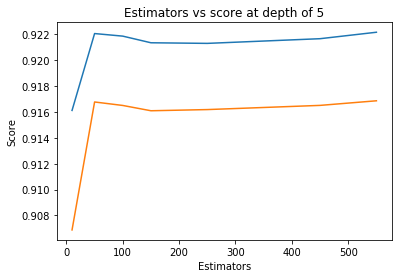

In [29]:
estimators = [10,50,100,150,250,450,550]
train_scores_rf = []
test_scores_rf = []

for est in tqdm(estimators):
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,\
            min_impurity_decrease=0.0, min_impurity_split=None,\
            min_samples_leaf=52, min_samples_split=120,\
            min_weight_fraction_leaf=0.0, n_estimators = est, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(train_df_final,y_train)
    train_score = f1_score(y_train,clf.predict(train_df_final))
    test_score = f1_score(y_test,clf.predict(test_df_final))
    test_scores_rf.append(test_score)
    train_scores_rf.append(train_score)
    print('Estimators = ',est,'Train Score',train_score,'test Score',test_score)
    
plt.plot(estimators,train_scores_rf,label='Train Score')
plt.plot(estimators,test_scores_rf,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [30]:
est_ = [i for i in test_scores_rf]
best_est = estimators[np.argmax(est_)]
print("optimal estimator no :",best_est)

optimal estimator no : 550


<h3> Depth </h3>

depth =  3 Train Score 0.8910689980106796 test Score 0.8672813036020584
depth =  5 Train Score 0.9221608361551122 test Score 0.9168636056718434
depth =  7 Train Score 0.9375684099698737 test Score 0.9211736044910497
depth =  9 Train Score 0.9585888316572644 test Score 0.9227416966363444
depth =  11 Train Score 0.9626125345377801 test Score 0.9237700410338848
depth =  15 Train Score 0.9648620854673007 test Score 0.9245634064865322
depth =  20 Train Score 0.9649306864133148 test Score 0.9242904876707694
depth =  35 Train Score 0.9648645620040138 test Score 0.9240436696005417
depth =  50 Train Score 0.9648645620040138 test Score 0.9240436696005417


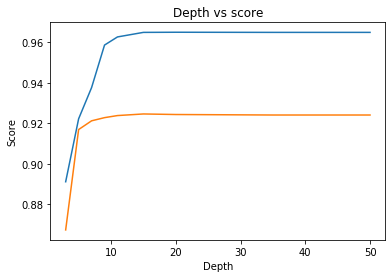

In [31]:
depths = [3,5,7,9,11,15,20,35,50]
train_scores_rf = []
test_scores_rf = []
for dep in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\
            max_depth=dep, max_features='auto', max_leaf_nodes=None,\
            min_impurity_decrease=0.0, min_impurity_split=None,\
            min_samples_leaf=52, min_samples_split=120,\
            min_weight_fraction_leaf=0.0, n_estimators=best_est, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(train_df_final,y_train)
    train_score = f1_score(y_train,clf.predict(train_df_final))
    test_score = f1_score(y_test,clf.predict(test_df_final))
    test_scores_rf.append(test_score)
    train_scores_rf.append(train_score)
    print('depth = ',dep,'Train Score',train_score,'test Score',test_score)
plt.plot(depths,train_scores_rf,label='Train Score')
plt.plot(depths,test_scores_rf,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score')
plt.show()

In [32]:
dep_ = [i for i in test_scores_rf]
best_dep = depths[np.argmax(dep_)]
print("optimal depth :",best_dep)

optimal depth : 15


<h3>Testing the model with optimal no of estimators and estimator depths</h3>

In [33]:
clf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\
            max_depth=5, max_features='auto', max_leaf_nodes=None,\
            min_impurity_decrease=0.0, min_impurity_split=None,\
            min_samples_leaf=52, min_samples_split=120,\
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
clf1.fit(train_df_final,y_train)
y_pred1_tr = clf1.predict(train_df_final)
y_pred1_te = clf1.predict(test_df_final)
train_score = f1_score(y_train,clf1.predict(train_df_final))
test_score = f1_score(y_test,clf1.predict(test_df_final))

print("Train f1 score for Random Forest Classifier is:",train_score)
print("Test f1 score for Random Forest Classifier is:",test_score)

Train f1 score for Random Forest Classifier is: 0.9213002297114445
Test f1 score for Random Forest Classifier is: 0.9161846049909218


 <h2>Random Forest hyperparameter tuning using RandomizedSearchCV </h2>

In [34]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint
from scipy.stats import uniform

params = {"n_estimators" : randint(150,250),
              "max_depth" : randint(10,15),
              "min_samples_split" : randint(120,200),
              "min_samples_leaf" : randint(30,65)
         }

clf = RandomForestClassifier(random_state = 100,n_jobs=-1)

rand_search = RandomizedSearchCV(clf, param_distributions = params,return_train_score=True,\
                                   n_iter = 5,cv = 10,scoring = 'f1',random_state = 100)

rand_search.fit(train_df_final,y_train)
print('mean test scores',rand_search.cv_results_['mean_test_score'])
print('mean train scores',rand_search.cv_results_['mean_train_score'])

mean test scores [0.96028299 0.96088241 0.96213302 0.96154282 0.96278208]
mean train scores [0.96106416 0.96150398 0.96310434 0.96240768 0.96368211]


In [35]:
print(rand_search.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=46, min_samples_split=129,
                       min_weight_fraction_leaf=0.0, n_estimators=243,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=0,
                       warm_start=False)


In [93]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=46, min_samples_split=129,
                       min_weight_fraction_leaf=0.0, n_estimators=243,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

clf.fit(train_df_final,y_train)
y_pred_tr = clf.predict(train_df_final)
y_pred_te = clf.predict(test_df_final)

print('Train f1 score',f1_score(y_train,y_pred_tr))
print('Test f1 score',f1_score(y_test,y_pred_te))

Train f1 score 0.9632732090084583
Test f1 score 0.921227285256886


Train confusion_matrix


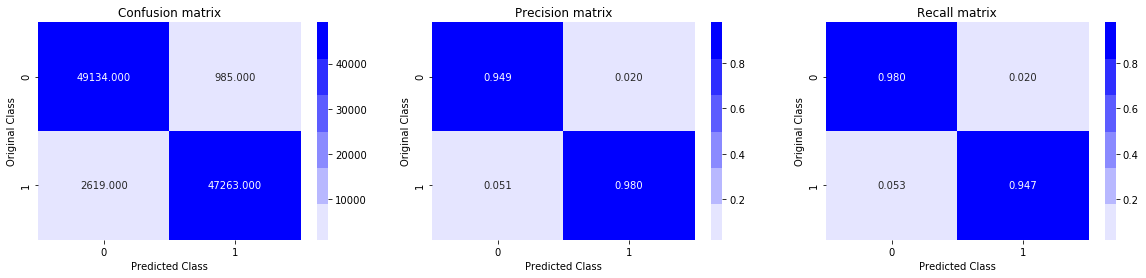

Test confusion_matrix


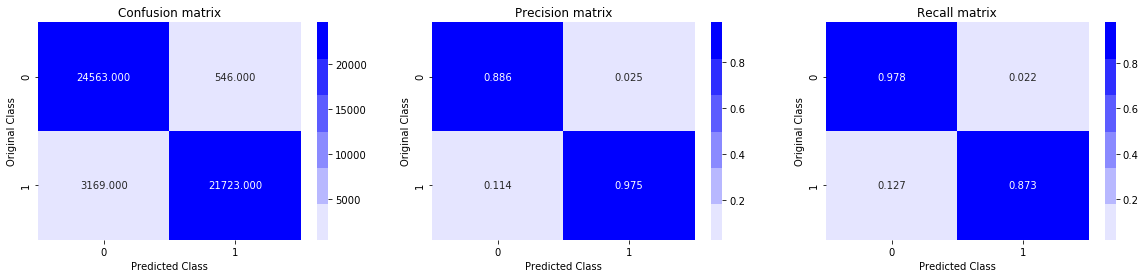

In [94]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_pred_tr)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_pred_te)

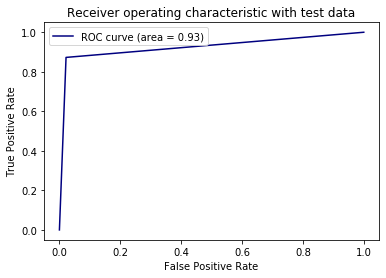

In [95]:
fpr,tpr,thresh = roc_curve(y_test,y_pred_te)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

<h3>Feature Importance:Random Forest (hyperparameter tuning using RandomSearchcv) </h3>

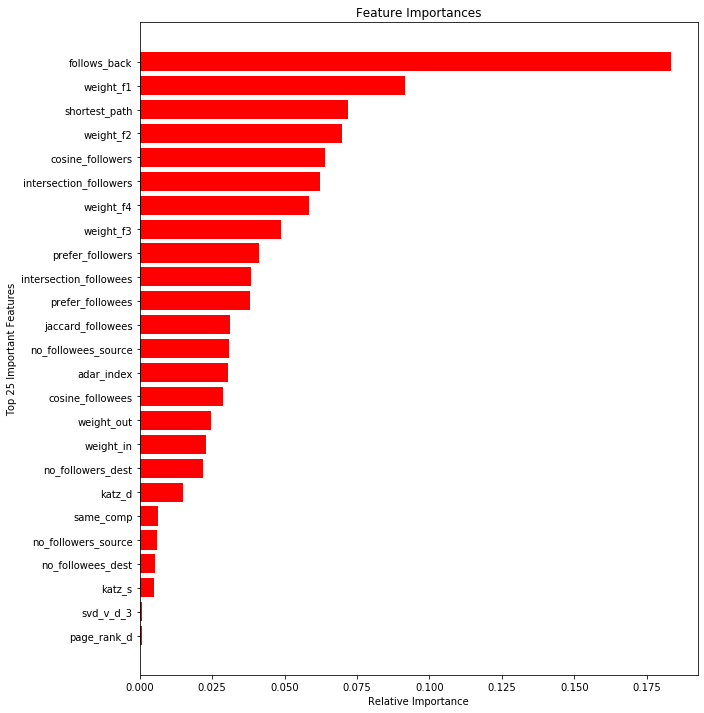

In [96]:
feat = train_df_final.columns
clf_feat_imp = clf.feature_importances_
imp_idx = (np.argsort(clf_feat_imp))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(imp_idx)), clf_feat_imp[imp_idx], color='r', align='center')
plt.yticks(range(len(imp_idx)), [feat[i] for i in imp_idx])
plt.xlabel('Relative Importance')
plt.ylabel('Top 25 Important Features')
plt.show()

<h2> XGBOOST </h2>

<h3>Hyperparameter tuning using RandomizedSearchCV </h3>

In [70]:
clf = xgb.XGBClassifier(n_jobs = -1)

params = {"n_estimators": randint(105,200),
              "max_depth": randint(10,15)
              }
xg_optclf = RandomizedSearchCV(clf, param_distributions = params, n_iter=5,cv=3, scoring='f1',return_train_score=True, random_state=100)
xg_optclf.fit(train_df_final,y_train)

print('Mean test scores :\n',xg_optclf.cv_results_['mean_test_score'])
print('\n Mean train scores : \n',xg_optclf.cv_results_['mean_train_score'])

Mean test scores :
 [0.98108792 0.98097069 0.9806272  0.98057954 0.98071017]

 Mean train scores : 
 [0.99811247 1.         0.99603833 1.         0.9995387 ]


In [88]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


clf.fit(train_df_final,y_train)
y_pred_tr = clf.predict(train_df_final)
y_pred_te = clf.predict(test_df_final)

print('Train f1 score',f1_score(y_train,y_pred_tr))
print('Test f1 score',f1_score(y_test,y_pred_te))

Train f1 score 0.9810128505027798
Test f1 score 0.9272219974015463


Train confusion_matrix


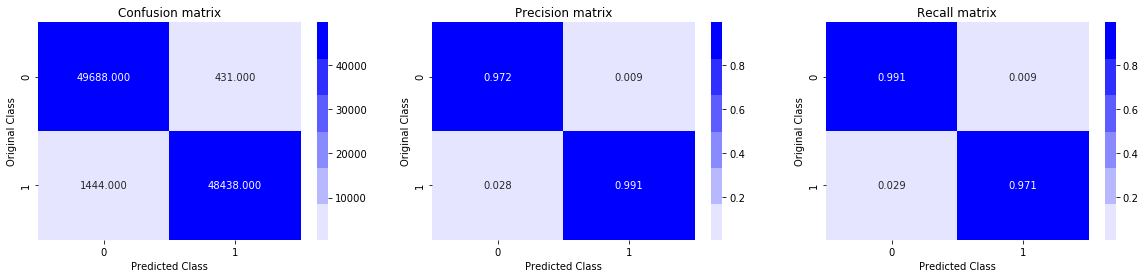

Test confusion_matrix


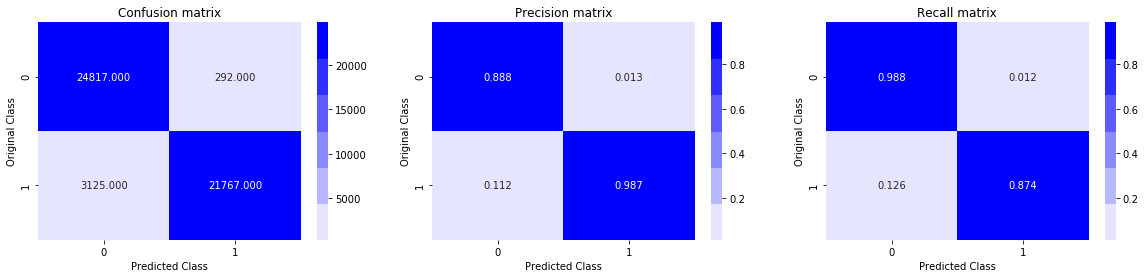

In [89]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_pred_tr)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_pred_te)

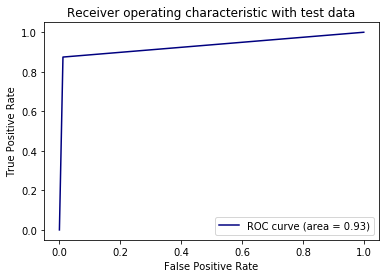

In [90]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_pred_te)
auc_scale = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_scale)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

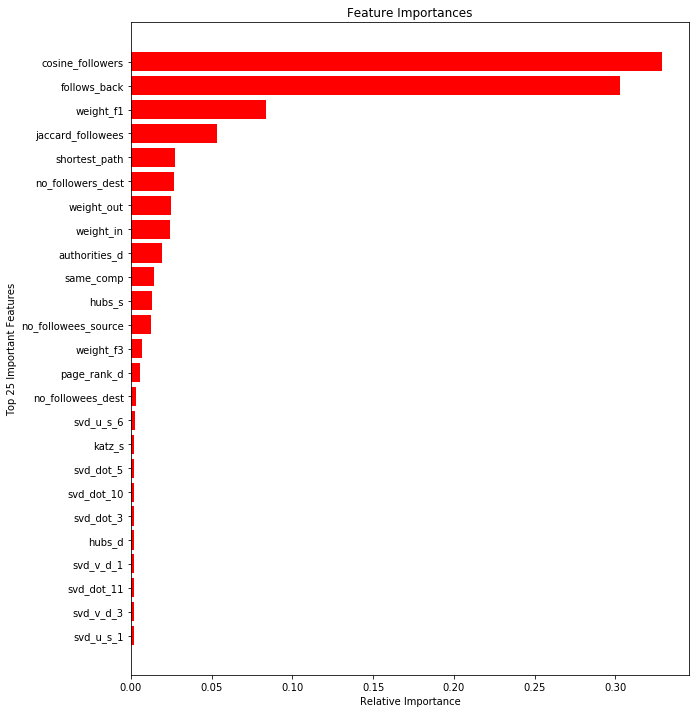

In [91]:
feat = train_df_final.columns
clf_feat_imp = clf.feature_importances_
imp_idx = (np.argsort(clf_feat_imp))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(imp_idx)), clf_feat_imp[imp_idx], color='r', align='center')
plt.yticks(range(len(imp_idx)), [feat[i] for i in imp_idx])
plt.xlabel('Relative Importance')
plt.ylabel('Top 25 Important Features')
plt.show()


<h2><div style = "color:blue;">Pretty Table</div></h2>

In [ ]:
Train f1 score 732090084583
Test f1 score 27285256886

In [97]:
from prettytable import PrettyTable 
y = PrettyTable()
y.field_names = ["Model", "n_estimators", "max_depth", "Train f1-Score","Test f1-Score"]
y.add_row(['Random Forest','243','12','0.9632','0.9212'])
y.add_row(['XGBOOST','150','12','0.9810','0.9272'])
print(y)

+---------------+--------------+-----------+----------------+---------------+
|     Model     | n_estimators | max_depth | Train f1-Score | Test f1-Score |
+---------------+--------------+-----------+----------------+---------------+
| Random Forest |     243      |     12    |     0.9632     |     0.9212    |
|    XGBOOST    |     150      |     12    |     0.9810     |     0.9272    |
+---------------+--------------+-----------+----------------+---------------+


<h2><div style = "color:blue;">Observations</div></h2>

1) First we performed exploratory data analysis on our given data set such as number of followers and followees of each person etc.

2) Since we had only class 1 labelled data. Then after we generated "missing links" or datapoints which were not present in our given data-set.

3) We did lots of feature engineering on data like finding shortest path, kartz centrality, jaccard distances, page rank, preferential attachements etc as only edge information was present initially.

4) Then we splitted whole dataset into train and test, joined the edges and missing links data together in both train and test set and performed Random forest and xgboost taking f1-score as our metric.

5) We also showed the top 25 important features that were used in the classification.

6) Although among the top 25 features in xgbClassifier only a few of them(eg follows back, cosine followers etc) were usful.The Model may be underfitting also.

7) At the end we plotted confusion matrix and pretty-table for both algorithm and found best hyperparameters.